In [54]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import autograd as ad
import autograd.numpy as np
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def coupled_spectrum(phi_ex,beta,N,Ej,Ec,omega_c,g_intfa):
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    
    cdim = 10
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int =  g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    H_int = g_int*np.kron(s+sd,cd+c)
#     H_int = g_int*(np.kron(sd,c)+np.kron(s,cd))
    H = Hs + Hc + H_int
    grounds = np.zeros(sdim)
    grounds[0]=1
    fock1 = np.zeros(cdim)
    fock1[1]=1
    fock1 = np.kron(grounds,fock1)
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    max_overlap = 0
    max_index = -1
    # Loop over each dressed state
    for i in range(dressed_states.shape[1]):
        # Calculate overlap
        overlap = np.abs(np.vdot(dressed_states[:, i], fock1))**2
        # Check if this overlap is greater than the current maximum
        if overlap > max_overlap:
            max_overlap = overlap
            max_index = i
    exact = energy[max_index]/2/np.pi
    return exact, omega_s

def coupled_spectrumapp(phi_ex,beta,N,Ej,Ec,omega_c,g_intfa):
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    
    energy,dressed_states = np.linalg.eigh(Hs)
    energy = energy-energy[0]*np.ones(len(energy))
    omega_sp = energy[1]
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)
    g4 = Ej*phi_zpf**4*c4/4/3/2
#     omega_sp = omega_s +12*(g4-5*g3/omega_s**2-24*g4**2/omega_s)
    g_int =  0.1*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    deltap = omega_c - omega_sp
    addp = omega_c + omega_sp
    delta = omega_c - omega_s
    add = omega_c + omega_s
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    Hs = omega_sp * np.matmul(sd,s) 
    cdim = 10
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int =  g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    p1 = - 6*g4*s +2*g3*s@s  - 6*g4*sd@s@s+g4*s@s@s 
    app2 = s+sd+1/omega_s*(-12*g3*sd@s+ p1 + np.transpose(p1.conjugate()))
    dressed_states_dagger = np.conjugate(dressed_states.transpose())
#     s_int = dressed_states_dagger@(s+sd)@dressed_states
    D = int_swt(g3,g4,omega_s,s,sd,1)[1]
    U = expm(-D)
    int_s = np.transpose(U.conjugate())@(s+sd)@U
    H_int = g_int*np.kron(app2,cd+c)
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    exact = energy[1]/2/np.pi
#     +20*(g3/omega_s)**2+300*(g4/omega_s)**2
    return (omega_c + g_int**2/deltap)/2/np.pi,(omega_c + g_int**2/delta - g_int**2/add)/2/np.pi,(omega_c + (g_int)**2/deltap - (g_int)**2/addp)/2/np.pi,g4/2/np.pi,g3/2/np.pi,omega_sp/2/np.pi, exact,(1-6*g4/omega_s)


In [55]:
from qutip import qload
from sympy.physics.secondquant import *
from sympy import symbols
import sympy as sp
from cosmatrix import expm_pade
def int_swt(g3,g4,omegas,s,sd,order):    
    s1,s2,s3 = qload('./symbolic/swt')
    omegasp = symbols('omega', real=True)
    g3sp = symbols('g3', real=True)
    g4sp = symbols('g4', real=True)
    omega = symbols('omega', real=True)
    kappa = symbols('kappa', real=True)
    ind_a = symbols('a')
    a = B(ind_a)
    ad = Bd(ind_a)
    def replace_scalars_with_valued_matrices(expr, matrix_values):
        """
        Replace scalar symbols and scalar operations in a SymPy scalar expression with valued matrices.

        Args:
        expr (sympy.Expr): The input scalar expression.
        matrix_values (dict): A dictionary mapping scalar symbols to valued matrices.

        Returns:
        sympy.Expr: The modified expression with valued matrices.
        """

        def map_operations(node):
            if (isinstance(node, AnnihilateBoson) or isinstance(node, CreateBoson) )and node in matrix_values:
                return matrix_values[node]
            elif isinstance(node, sp.Add):
                return sp.Add(*[map_operations(arg) for arg in node.args])
            elif isinstance(node, sp.Mul):
                return sp.Mul(*[map_operations(arg) for arg in node.args])
            elif isinstance(node, sp.Pow):
                base, exponent = map_operations(node.base), map_operations(node.exp)
                return base**exponent
            else:
                return node

        return map_operations(expr)
    def smatrix(expr):
        expr = expr.subs({ g3sp:g3[0],g4sp:g4[0], kappa:1,omegasp:omegas[0]})
        sp_s = sp.Matrix(s)
        sp_sd = sp.Matrix(sd)
        matrix_values = {a: sp_s, ad: sp_sd}
        result = replace_scalars_with_valued_matrices(expr, matrix_values)
        return np.array(result,np.float64)
    if order == 1:
        D = smatrix(s1)
    if order == 2:
        D = smatrix(s1) + smatrix(s2) 
    if order == 3:
        D = smatrix(s1) + smatrix(s2) + smatrix(s3)
    app = expm(D)@(s+sd)@expm(-D)
    return app,D

In [68]:
beta = 0.15
omega_c = 8*2*np.pi
g_intfa=0.15
N = 3
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
phi_exs = np.linspace(0.0*2*np.pi,1*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
snail_energiesapp1 = np.zeros(len(phi_exs))
snail_energiesapp2 = np.zeros(len(phi_exs))
snail_energiesapp3 = np.zeros(len(phi_exs))
dressed_omegas = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
omega_sps = np.zeros(len(phi_exs))
Hs34 = np.zeros(len(phi_exs))
facs = np.zeros(len(phi_exs))
for i in range(len(phi_exs)):
    snail_energies[i],dressed_omegas[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec,omega_c,g_intfa)
    snail_energiesapp1[i],snail_energiesapp2[i],snail_energiesapp3[i], g4s[i],g3s[i],omega_sps[i],Hs34[i],facs[i]= coupled_spectrumapp(phi_exs[i],beta,N,Ej,Ec,omega_c,g_intfa)

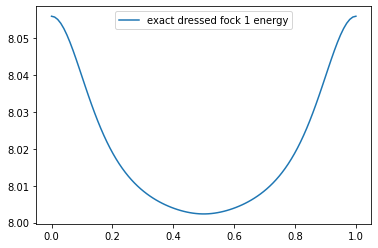

In [69]:
plt.plot(phi_exs/2/np.pi,snail_energies,label = 'exact dressed fock 1 energy')
# plt.scatter((phi_exs/2/np.pi)[-13],snail_energies[-14])
# plt.plot(phi_exs/2/np.pi,Hs34-omega_c/2/np.pi*np.ones(100), label = '1st order to $s+s^\dagger$')
# plt.plot(phi_exs/2/np.pi,snail_energiesapp2, label = '$g^2/\Delta - g^2/(\omega_c+\omega_s)$')
# plt.plot(phi_exs/2/np.pi,(snail_energiesapp3), label = '$g^2/\Delta - g^2/(\omega_c+\omega_s)$')
# plt.plot(phi_exs/2/np.pi,(snail_energiesapp3)*facs**2, label = '$g^{\'2}/\Delta^{\'} - g^{\'2}/(\omega_c+\omega_s^{\'})$, $g^{\'}=g*(1-6g_4/ω_s)$')
plt.legend()

In [245]:
# check paramereters - g/delta
# calculate t2 - see improvement
# drive - engineer factor 

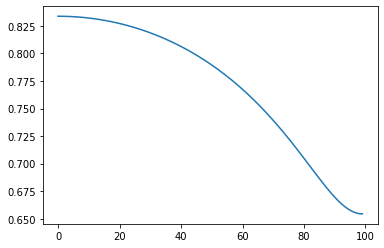

In [284]:
plt.plot(facs)

In [225]:
def coupled_spectrumapp(phi_ex,beta,N,Ej,Ec,omega_c):
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    
    energy,dressed_states = np.linalg.eigh(Hs)
    energy = energy-energy[0]*np.ones(len(energy))
    omega_sp = energy[1]
    g_int =  0.1*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    deltap = omega_c - omega_sp
    addp = omega_c + omega_sp
    delta = omega_c - omega_s
    add = omega_c + omega_s
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)
    g4 = Ej*phi_zpf**4*c4/4/3/2
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    Hs = omega_sp * np.matmul(sd,s) 
    cdim = 10
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int =  0.1*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    dressed_states_dagger = np.conjugate(dressed_states.transpose())
#     s_int = dressed_states_dagger@(s+sd)@dressed_states
    D = int_swt(g3,g4,omega_s,s,sd,1)[0]
#     U = expm(-D)
#     int_s = np.transpose(U.conjugate())@(s+sd)@U
    H_int = g_int*np.kron(D,cd+c)
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    exact1 = energy[1]/2/np.pi
    D = int_swt(g3,g4,omega_s,s,sd,2)[0]
#     U = expm(-D)
#     int_s = np.transpose(U.conjugate())@(s+sd)@U
    H_int = g_int*np.kron(D,cd+c)
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    exact2 = energy[1]/2/np.pi
    return exact1,exact2


In [226]:
phi_exs = np.linspace(0.0*2*np.pi,0.5*2*np.pi,100)
grad = ad.grad(coupled_spectrum)
snail_energies = np.zeros(len(phi_exs))
snail_energiesapp1 = np.zeros(len(phi_exs))
snail_energiesapp2 = np.zeros(len(phi_exs))
snail_energiesapp3 = np.zeros(len(phi_exs))
dressed_omegas = np.zeros(len(phi_exs))
g4s = np.zeros(len(phi_exs))
g3s = np.zeros(len(phi_exs))
omega_sps = np.zeros(len(phi_exs))
Hs34 = np.zeros(len(phi_exs))
for i in range(len(phi_exs)):
    snail_energies[i],dressed_omegas[i] = coupled_spectrum(phi_exs[i],beta,N,Ej,Ec,omega_c)
    snail_energiesapp1[i],snail_energiesapp2[i]= coupled_spectrumapp(phi_exs[i],beta,N,Ej,Ec,omega_c)

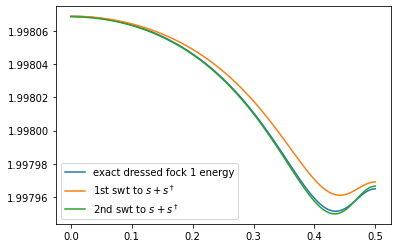

In [227]:
plt.plot(phi_exs/2/np.pi,snail_energies,label = 'exact dressed fock 1 energy')
plt.plot(phi_exs/2/np.pi,snail_energiesapp1, label = '1st swt to $s+s^\dagger$')
plt.plot(phi_exs/2/np.pi,snail_energiesapp2, label = '2nd swt to $s+s^\dagger$')

plt.legend()